<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/tpu_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics

In [1]:
#!wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

--2021-06-17 10:56:37--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘CheXpert-v1.0-small.zip’

CheXpert-v1.0-small 100%[===================>]  10.76G  4.95MB/s    in 36m 58s 

2021-06-17 11:33:35 (4.97 MB/s) - ‘CheXpert-v1.0-small.zip’ saved [11557753157/11557753157]



In [2]:
%%capture
#!unzip /content/CheXpert-v1.0-small.zip

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
train=pd.read_csv('/content/CheXpert-v1.0-small/train.csv')
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [60]:
val=pd.read_csv('/content/CheXpert-v1.0-small/valid.csv')
val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
image_names = []
labels = []
import csv
def read_images(path):
  policy='ones'
  with open(path, "r") as f:
      csvReader = csv.reader(f)
      next(csvReader, None)
      k=0
      for line in csvReader:
          k+=1
          image_name= line[0]
          label = line[5:]
          
          for i in range(14):
              if label[i]:
                  a = float(label[i])
                  if a == 1:
                      label[i] = 1
                  elif a == -1:
                      if policy == "ones":
                          label[i] = 1
                      elif policy == "zeroes":
                          label[i] = 0
                      else:
                          label[i] = 0
                  else:
                      label[i] = 0
              else:
                  label[i] = 0
                  
          image_names.append(image_name)
          labels.append(label)
  return image_names,labels

In [69]:
train_image,train_label=read_images('/content/CheXpert-v1.0-small/train.csv')
val_image,val_label=read_images('/content/CheXpert-v1.0-small/valid.csv')

In [17]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
print(len(class_names))

14


In [45]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight

In [49]:
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [160]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,image,label,transform=None):
    super(DataReader,self).__init__()
    self.image=image
    self.label=label
    self.transform=transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image_path=self.image[index]
    image_label=self.label[index]

    #read data
    image=Image.open(image_path).convert('L')

    if self.transform:
      image=self.transform(image)

    return image,torch.tensor(image_label,dtype=torch.float32)

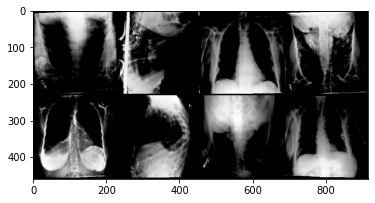

In [161]:
#code testing
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
train=DataReader(np.array(train_image),np.array(train_label),transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=8)
batch,_=next(iter(train_loader))
grid_img=torchvision.utils.make_grid(batch,4,4)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

In [162]:

import torch.nn as nn
class Fire1(nn.Module):
   
    def __init__(self, in_channels, squeeze_channels,expand_channels):
        super(Fire1, self).__init__()

        # squeeze 
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.LeakyReLU()

        # expand
        self.expand_1x1 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand_3x3 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3,padding=1)
        

    def forward(self, x):
        x = self.squeeze(x)
        x= self.relu(x)
        x = torch.cat([self.expand_1x1(x),self.expand_3x3(x)], dim=1)
        x = self.relu(x)
        return x
    
    
class MyModelV3(torch.nn.Module):
    
    def __init__(self,num_classes):
        super(MyModelV3, self).__init__()
        self.num_classes=num_classes
        self.net = torch.nn.Sequential(
                 nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.LeakyReLU(),
                 nn.BatchNorm2d(32),
                 Fire1(in_channels=32, squeeze_channels=16,expand_channels=32),
                 Fire1(in_channels=64, squeeze_channels=16,expand_channels=64),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.5),
                 Fire1(in_channels=128, squeeze_channels=32,expand_channels=96),
                 Fire1(in_channels=192, squeeze_channels=32,expand_channels=128),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.25),
                 Fire1(256, 48, 160),
                 Fire1(320, 48, 160),
                 nn.Dropout(0.5),
                 nn.Conv2d(in_channels=320,out_channels=128*2,kernel_size=1,stride=2),
                 nn.LeakyReLU(),
                 nn.Conv2d(in_channels=128*2,out_channels=32,kernel_size=1,stride=1),
                 nn.LeakyReLU(),
                 nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.LeakyReLU(),
                 nn.Dropout(0.5),
                 nn.Flatten(),
                 nn.Linear(784, self.num_classes),
                 nn.Sigmoid(),
                               
                )        
    def forward(self, x):
        return self.net(x)

In [163]:
x=torch.randn(1,1,224,224)
model=MyModelV3(14)
out=model(x)
out

tensor([[0.4990, 0.4908, 0.5170, 0.5045, 0.4992, 0.4863, 0.5173, 0.4964, 0.4885,
         0.5116, 0.4901, 0.4968, 0.4990, 0.4977]], grad_fn=<SigmoidBackward>)

In [164]:
criterion=nn.BCEWithLogitsLoss()
criterion(out,torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32))

tensor(0.9026, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [165]:
pred=torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32)
pred.shape,out.shape


(torch.Size([1, 14]), torch.Size([1, 14]))

In [166]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer =MyModelV3(len(class_names))
    
  #parameters
    self.batch_size=128
    self.numworker=1
    self.criterion=nn.BCELoss()
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    return torch.optim.Adam(params=self.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)

  def train_dataloader(self):
    return DataLoader(DataReader(np.array(train_image),np.array(train_label),aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(np.array(val_image),np.array(val_label),aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('vall/loss', loss, on_epoch=True,prog_bar=True)
    return loss

In [ ]:
early_stop_callback = EarlyStopping(monitor='vall/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
model = OurModel()
trainer = Trainer(max_epochs=10, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type      | Params
----------------------------------------
0 | layer     | MyModelV3 | 383 K 
1 | criterion | BCELoss   | 0     
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
0.768     Total estimated model params size (MB)


[rank: 4] Metric vall/loss improved. New best score: 0.432
[rank: 7] Metric vall/loss improved. New best score: 0.432
[rank: 1] Metric vall/loss improved. New best score: 0.431
[rank: 3] Metric vall/loss improved. New best score: 0.431
[rank: 5] Metric vall/loss improved. New best score: 0.433
[rank: 0] Metric vall/loss improved. New best score: 0.432
[rank: 6] Metric vall/loss improved. New best score: 0.432
[rank: 2] Metric vall/loss improved. New best score: 0.433
